<a href="https://colab.research.google.com/github/4d5645/StatsForDataAnalysis_MIPT/blob/main/Retention_performance_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retention performance analysis
Let's analyze the data of one of the American telecommunications companies about users who could potentially leave.

In [38]:
%pylab inline
import pandas as pd
import numpy as np
import scipy
import math
import statsmodels
from scipy import stats
import matplotlib.pyplot as plt
import warnings
import itertools
from itertools import product
from statsmodels.sandbox.stats.multicomp import multipletests
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


The following features were measured:

- state - US state

- account_length — account usage duration

- area_code - division of users into pseudo-regions, used in telecom

- intl_plan - whether the user has an international communication service

- vmail_plan - whether the user has a voice message service

- vmail_message - number of voice messages sent/received by the user

- day_calls - how many daily calls the user has made

- day_mins - how many minutes the user spoke during the day

- day_charge - how much the user paid for his daily activity
- eve_calls, eve_mins, eve_charge - similar metrics regarding evening activity

- night_calls, night_mins, night_charge - similar metrics regarding night activity

- intl_calls, intl_mins, intl_charge - similar metrics regarding international communication

- custserv_calls - how many times the user called the helpdesk

- treatment - number of the strategy that was used to retain subscribers (0, 2 = two different types of treatment, 1 = control group)

- mes_estim - assessment of the intensity of using Internet messengers

- churn - outflow result: whether the subscriber stopped using the services of the operator

In [39]:
from google.colab import drive
drive.mount('/content/gdrive')
data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/MIPT/churn_analysis.csv', index_col='Unnamed: 0')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [40]:
data.head()

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,...,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim,churn
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,...,244.7,91,11.01,10.0,3,2.70,1,1,0.65,False.
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,...,254.4,103,11.45,13.7,3,3.70,1,0,0.55,False.
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,...,162.6,104,7.32,12.2,5,3.29,0,0,0.72,False.
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,...,196.9,89,8.86,6.6,7,1.78,2,1,0.28,False.
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,...,186.9,121,8.41,10.1,3,2.73,3,2,0.45,False.


In [41]:
control = data[data.treatment == 1]
control.shape

(1097, 22)

In [42]:
table_states = pd.pivot_table(control, values='treatment', index='state', columns='churn', aggfunc=len, fill_value=0)
table_states.head()

churn,False.,True.
state,,
AK,19,1
AL,25,5
AR,11,5
AZ,17,2
CA,10,5


In [48]:
indx = table_states.index
indx

Index(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI',
       'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN',
       'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH',
       'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA',
       'WI', 'WV', 'WY'],
      dtype='object', name='state')

In [49]:
states_stats = pd.DataFrame(columns = ['first', 'second', 'chi2', 'p-value'])

In [55]:
i = 0
for frst, scnd in itertools.combinations(indx, 2):
  pair = table_states.loc[[frst, scnd], :]
  states_stats.loc[i, 'first'] = frst
  states_stats.loc[i, 'second'] = scnd
  states_stats.loc[i, 'chi2'] = scipy.stats.chi2_contingency(pair.values, correction=False)[0]
  states_stats.loc[i, 'p-value'] = scipy.stats.chi2_contingency(pair.values, correction=False)[1]
  i +=1

states_stats

,first,second,chi2,p-value
0,AK,AL,1.546717,0.213621
1,AK,AR,4.41,0.035729
2,AK,AZ,0.419079,0.517397
3,AK,CA,4.844349,0.027737
4,AK,CO,2.688636,0.101066
...,...,...,...,...
1270,WA,WV,1.720633,0.189612
1271,WA,WY,3.201581,0.073567
1272,WI,WV,0.666667,0.414216
1273,WI,WY,0.008297,0.927422


In [60]:
less_alpha = states_stats[states_stats['p-value'] < 0.05]
less_alpha.shape

(34, 4)

The xi-square test is based on the assumption that if the null hypothesis is true, then the discrete binomial distribution of data over cells in the contingency table can be approximated by a continuous xi-square distribution. However, the accuracy of such an approximation depends significantly on the total number of observations and their distribution in this table (hence the limitations when using the xi-square test).


In [61]:
i = 0
for frst, scnd in itertools.combinations(indx, 2):
  pair = table_states.loc[[frst, scnd], :]
  states_stats.loc[i, 'first'] = frst
  states_stats.loc[i, 'second'] = scnd
  states_stats.loc[i, 'chi2'] = scipy.stats.chi2_contingency(pair.values, correction=True)[0]
  states_stats.loc[i, 'p-value'] = scipy.stats.chi2_contingency(pair.values, correction=True)[1]
  i +=1

states_stats

,first,second,chi2,p-value
0,AK,AL,0.639205,0.423999
1,AK,AR,2.7225,0.098943
2,AK,AZ,0.002138,0.963119
3,AK,CA,3.054957,0.080491
4,AK,CO,1.435795,0.230821
...,...,...,...,...
1270,WA,WV,0.961945,0.326697
1271,WA,WY,2.006546,0.156622
1272,WI,WV,0.166667,0.683091
1273,WI,WY,0.187207,0.665252


In [62]:
less_alpha = states_stats[states_stats['p-value'] < 0.05]
less_alpha.shape

(0, 4)

The number of significance levels less than 0.05 achieved is exactly zero. That is, the correction has increased the achieved significance levels so much that none of the values ​​of the achieved significance level falls within the range from 0 to 0.05.

The achieved significance levels on our data, obtained using the Yates-corrected xi-square test, are on average larger than the corresponding uncorrected values.

What if we don’t have enough data, we don’t want to use a continuous approximation of a discrete distribution and use a questionable correction, the xi-squared test assumptions are not met, but we need to test the hypothesis that the data belongs to the same distribution?

In this case, one resorts to the so-called Fisher's exact test. This criterion does not use approximations and accurately calculates the value of the achieved level of significance using a combinatorial approach.


In [64]:
i = 0
for frst, scnd in itertools.combinations(indx, 2):
  pair = table_states.loc[[frst, scnd], :]
  states_stats.loc[i, 'first'] = frst
  states_stats.loc[i, 'second'] = scnd
  states_stats.loc[i, 'chi2'] = scipy.stats.fisher_exact(pair.values)[0]
  states_stats.loc[i, 'p-value'] = scipy.stats.fisher_exact(pair.values)[1]
  i +=1

states_stats

,first,second,chi2,p-value
0,AK,AL,3.8,0.381063
1,AK,AR,8.636364,0.068862
2,AK,AZ,2.235294,0.60499
3,AK,CA,9.5,0.063965
4,AK,CO,5.588235,0.187034
...,...,...,...,...
1270,WA,WV,0.42328,0.207829
1271,WA,WY,0.228571,0.134552
1272,WI,WV,2.037037,0.686168
1273,WI,WY,1.1,1.0


In [65]:
print('Pearson correlation: %.4f' % stats.pearsonr(data.day_calls, data.mes_estim)[0])
print('P-value: %.4f' % stats.pearsonr(data.day_calls, data.mes_estim)[1])

Pearson correlation: -0.0518
P-value: 0.0028


In [66]:
print('Spearman correlation: %.4f' % stats.spearmanr(data.day_calls, data.mes_estim)[0])
print('P-value: %.4f' % stats.spearmanr(data.day_calls, data.mes_estim)[1])

Spearman correlation: 0.0433
P-value: 0.0123


((array([-3.5297919 , -3.28786833, -3.15418238, ...,  3.15418238,
          3.28786833,  3.5297919 ]),
  array([0.05, 0.05, 0.05, ..., 0.89, 0.91, 0.96])),
 (0.13861708020693372, 0.4842364236423642, 0.9996050483985331))

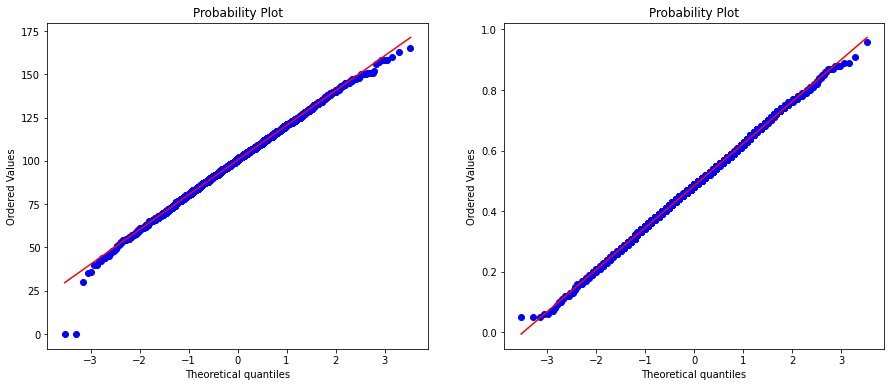

In [67]:
plt.figure(figsize=(15,6))
plt.subplot(121)
scipy.stats.probplot(data.day_calls, dist="norm", plot=plt)
plt.subplot(122)
scipy.stats.probplot(data.mes_estim, dist="norm", plot=plt)

In [68]:
def cramers_stat(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))


In [69]:
print('V Cramer stat value: %.4f' % cramers_stat(table_states.values))

V Cramer stat value: 0.2004
